## Project CXR Anomaly Detection

changes according wp from NPJ

Notebook 4 is the Notebook changed to work with TF 2.3+

In [1]:
# upgrade TF version to 2.3
# !pip install -U tensorflow==2.3.1 >> /dev/null
# !pip install cloud-tpu-client >> /dev/null

In [2]:
import tensorflow as tf 
# from cloud_tpu_client import Client

# check the current TF version
print(tf.__version__)
# Client().configure_tpu_version(tf.__version__, restart_type='ifNeeded')

2.2.0


In [3]:
# eventually install EfficientNets
# or other needed packages
!pip install -q efficientnet >> /dev/null

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
# this Notebook is the fourth to work on my CXR TFREC Dataset
# the dataset contains, in TFREC format, all images taken from NIH CXR dataset
# image have been transformed from initial format (png, 1024x1024)
# to JPEG 256x256 and packed in TFREC files

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from kaggle_datasets import KaggleDatasets

import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import os
import re, math
import time

In [5]:
# to remove some warnings

# TF2 way to reduce logging
# this remove also INFO, verify if needed
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [6]:
DEVICE = "TPU" # or "TPU"

# TFRecords file for training/validation
GCS_PATH = KaggleDatasets().get_gcs_path('cxr-tfrec256-may2020')

IMG_SIZES = 256

IMAGE_SIZE = [IMG_SIZES, IMG_SIZES]

# tune it, dependes on Image, size, TPU or GPU
#BATCH_SIZE = 64
BATCH_SIZE = 24

EPOCHS = 50

# for K-fold CV
FOLDS = 5

# WHICH EFFICIENTNET TO USE (B?, B0 from B7)
EFF_NETS = 2

In [7]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE == "GPU":
    n_gpu = len(tf.config.experimental.list_physical_devices('GPU'))
    print("Num GPUs Available: ", n_gpu)
    
    if n_gpu > 1:
        print("Using strategy for multiple GPU")
        strategy = tf.distribute.MirroredStrategy()
    else:
        print('Standard strategy for GPU...')
        strategy = tf.distribute.get_strategy()

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
REPLICAS: 8


### Code for Image Augmentation (taken from CDeotte work)

In [8]:
# changed
ROT_ = 20.0
SHR_ = 2.0
# changed
HZOOM_ = 4.0
WZOOM_ = 4.0
# changed
HSHIFT_ = 4.0
WSHIFT_ = 4.0

# image augmentation
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))

def transform(image, DIM=256):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

In [9]:
# not using metadata (only image, for now)
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_idx": tf.io.FixedLenFeature([], tf.string),
        'label' : tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    
    # do image augmentation
    image = transform(image, DIM=IMG_SIZES)
    # hearth on the right is not labeled as anomaly, therefore it is ok to flip
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
        
    image_idx = example['image_idx']
    label = example['label']
        
    return image, label 

def read_labeled_tfrecord_for_test(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_idx": tf.io.FixedLenFeature([], tf.string),
        'label' : tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    
    # DON't do image augmentation
    label = example['label']
        
    return image, label 

def decode_image(image_data):
    # qua dovrebbe fare la conversione in RGB come richiesto da EfficientNet
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

# count # of images in files.. (embedded in file name)
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [10]:
def load_dataset(filenames, labeled=True, ordered=False, isTest=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    
    if isTest == False:
        dataset = dataset.map(read_labeled_tfrecord)
    else:
        dataset = dataset.map(read_labeled_tfrecord_for_test)
    
    # returns a dataset of (image, labels) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset(filenames):
    dataset = load_dataset(filenames, labeled=True, isTest = False)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_valid_dataset(filenames):
    dataset = load_dataset(filenames, labeled=True, isTest = True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(filenames):
    # for predictions it is crucial the ordering
    dataset = load_dataset(filenames, labeled=True, isTest = True, ordered=True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

In [11]:
# here we define the DNN Model

EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

# as default it used B0

def build_model(dim = IMG_SIZES, ef = 0):
    inp = tf.keras.layers.Input(shape=(*IMAGE_SIZE, 3))
    
    base = EFNS[ef](input_shape=(*IMAGE_SIZE, 3), weights='imagenet', include_top = False)
    
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs = inp,outputs = x)
    
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
    
    fn_loss = tf.keras.losses.BinaryCrossentropy() 
    
    # loss = [focal_loss]
    model.compile(optimizer = opt, loss = [fn_loss], metrics=['AUC', 'accuracy'])
    
    return model

In [12]:
# build to have a summary of the model architecture
try_model = build_model(dim=IMG_SIZES, ef=EFF_NETS)

try_model.summary()

31940608/31936256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnet-b2 (Model)      (None, 8, 8, 1408)        7768562   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1409      
Total params: 7,769,971
Trainable params: 7,702,403
Non-trainable params: 67,568
_________________________________________________________________


In [13]:
# here we define the temporal behaviour of the learning rate

def get_lr_callback(batch_size=8):
    lr_start   = 0.00001
    lr_max     = 0.000015 * 10
    # lr_max     = 0.00001 * 20
    lr_min     = 0.00001
    lr_ramp_ep = 20
    # lr_ramp_ep = 20
    lr_sus_ep  = 10
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)
    
    return lr_callback

In [14]:
all_files = tf.io.gfile.glob(GCS_PATH + '/train_valid*.tfrec')
num_total_files = len(all_files)

n_images = count_data_items(all_files)

print('Total number of image for train-validation:', n_images)

Total number of image for train-validation: 10280


In [15]:
def train_one_fold(fold, files_train, files_valid):
    # train_files = list of train_files names
    # valid_files = list of valid files
    
    # constant to customize output
    VERBOSE = 1
    tStart = time.time()
    
    # BUILD MODEL
    if DEVICE=='TPU':
        # to avoid OOM
        tf.tpu.experimental.initialize_tpu_system(tpu)
    
    K.clear_session()
    with strategy.scope():
        print('Building model...')
        model = build_model(dim=IMG_SIZES, ef=EFF_NETS)
    
    # callback to save best model for each fold
    sv = tf.keras.callbacks.ModelCheckpoint('fold-%i.h5'%fold, monitor='val_loss', verbose=1, save_best_only=True,
                                            save_weights_only=True, mode='min', save_freq='epoch')
    
    # TRAIN
    history = model.fit(get_training_dataset(files_train), 
                        epochs=EPOCHS, 
                        callbacks = [sv, get_lr_callback(BATCH_SIZE)], 
                        steps_per_epoch = count_data_items(files_train)/BATCH_SIZE//REPLICAS,
                        validation_data = get_valid_dataset(files_valid), 
                        validation_steps = count_data_items(files_valid)/BATCH_SIZE//REPLICAS,
                        verbose=VERBOSE)
    
    tElapsed = round(time.time() - tStart, 1)
    
    print(' ')
    print('Time (sec) elapsed: ', tElapsed)
    print('...')
    print('...')
    
    return history

In [16]:
# code to manage K-fold CV
SHOW_FILES = True

skf = KFold(n_splits = FOLDS, shuffle = True, random_state=42)

# for others investigations
# we store all the history
histories = []

for fold,(idxT,idxV) in enumerate(skf.split(np.arange(num_total_files))):
    # display fold info
    print('')
    print('#'*60) 
    print('#### FOLD', fold+1)
    
    print('#### Image Size %i, EfficientNet B%i, batch_size %i'%
          (IMG_SIZES, EFF_NETS, BATCH_SIZE*REPLICAS))
    print('#### Epochs: %i' %(EPOCHS))
    print('#'*60)
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    train_files = tf.io.gfile.glob([GCS_PATH + '/train_valid%.2i*.tfrec'%x for x in idxT])
    valid_files = tf.io.gfile.glob([GCS_PATH + '/train_valid%.2i*.tfrec'%x for x in idxV])
    
    if SHOW_FILES:
        print('Number of training images', count_data_items(train_files))
        print('Number of validation images', count_data_items(valid_files))
    
    # in files h5 fol are numbered starting from 1
    
    # here launch the training for the fold
    history = train_one_fold(fold+1, train_files, valid_files)
    
    histories.append(history)


############################################################
#### FOLD 1
#### Image Size 256, EfficientNet B2, batch_size 192
#### Epochs: 50
############################################################
Number of training images 7280
Number of validation images 3000
Building model...

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/50
37/37 [==============================] - ETA: 0s - auc: 0.5375 - accuracy: 0.5214 - loss: 0.6886
Epoch 00001: val_loss improved from inf to 0.72454, saving model to fold-1.h5
37/37 [==============================] - 19s 511ms/step - auc: 0.5375 - accuracy: 0.5214 - loss: 0.6886 - val_auc: 0.5270 - val_accuracy: 0.4750 - val_loss: 0.7245 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 1.7e-05.
Epoch 2/50
37/37 [==============================] - ETA: 0s - auc: 0.6640 - accuracy: 0.6059 - loss: 0.6620
Epoch 00002: val_loss improved from 0.72454 to 0.68942, saving model to fold-1.h5
37/37 [==========

### code to plot AUC and loss during the epochs

In [17]:
def plot_auc(hist):
    plt.figure(figsize=(14,6))
    
    plt.plot(hist.history['auc'], label='Training auc')
    plt.plot(hist.history['val_auc'], label='Validation auc')
    plt.title('AUC')
    plt.legend(loc='lower right')
    plt.ylabel('AUC')
    plt.xlabel('epoch')
    plt.grid()
    plt.show();

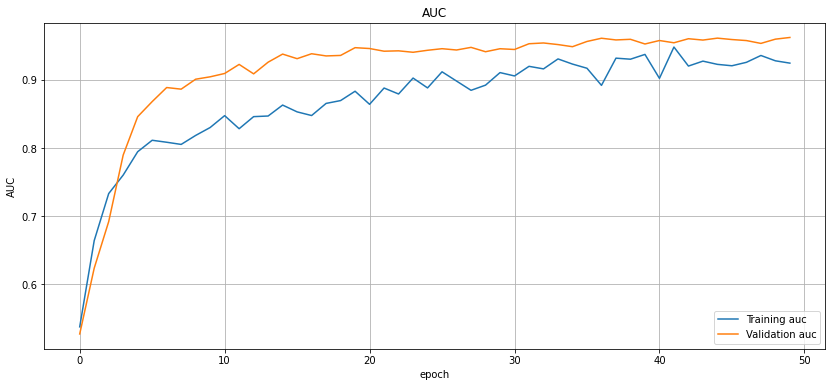

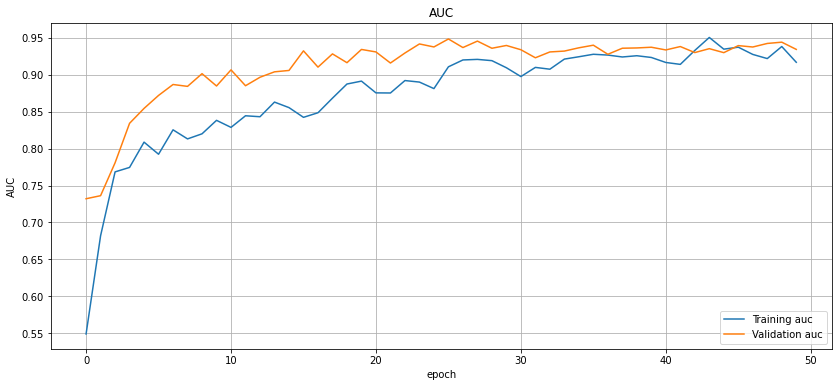

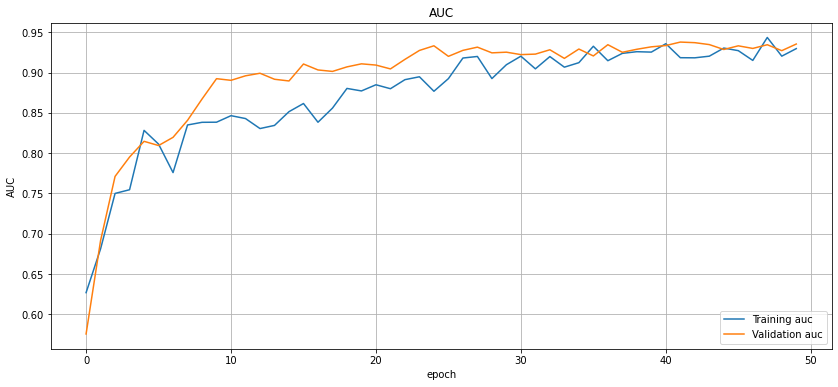

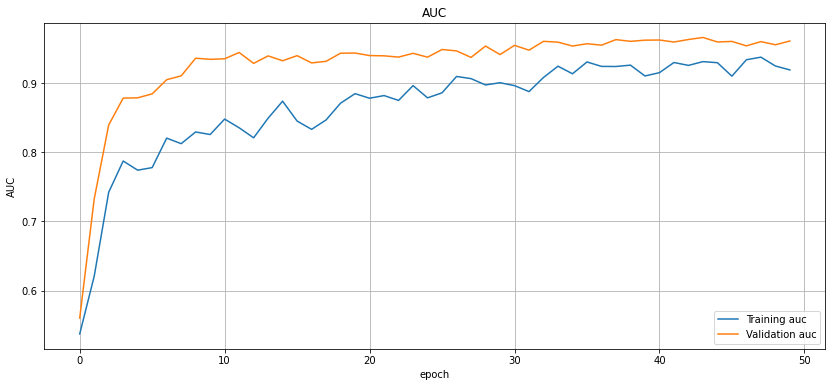

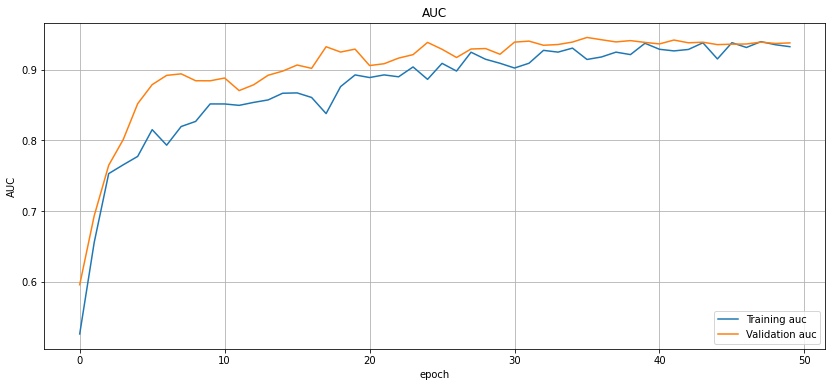

In [18]:
for fold in range(0, FOLDS):
    plot_auc(histories[fold])

In [19]:
def plot_loss(hist):
    plt.figure(figsize=(14,6))
    
    plt.plot(hist.history['loss'], label='Training loss')
    plt.plot(hist.history['val_loss'], label='Validation loss')
    plt.title('Loss')
    plt.legend(loc='lower right')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.grid()
    plt.show();

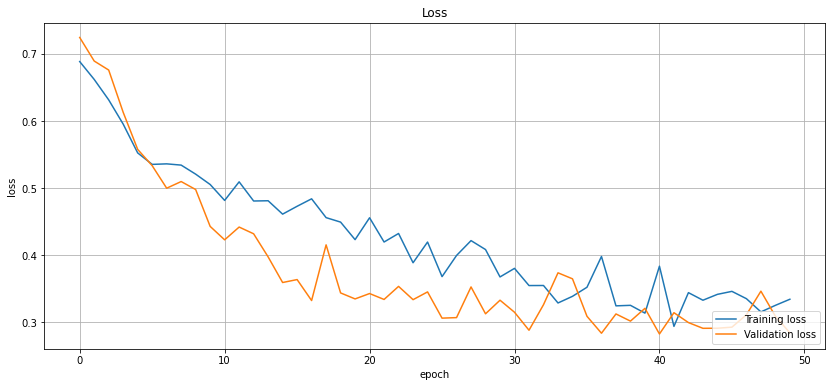

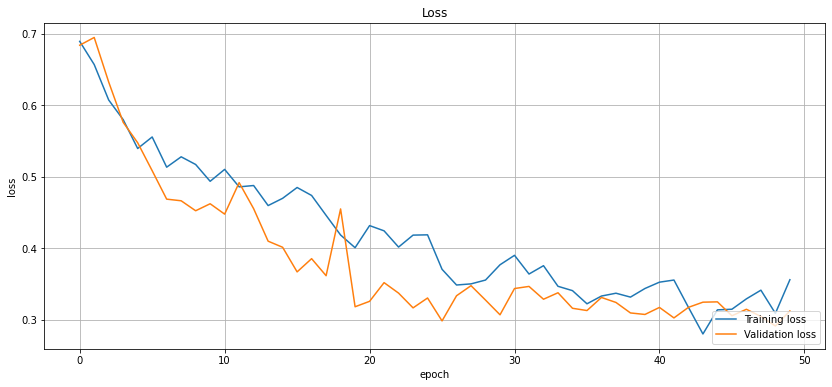

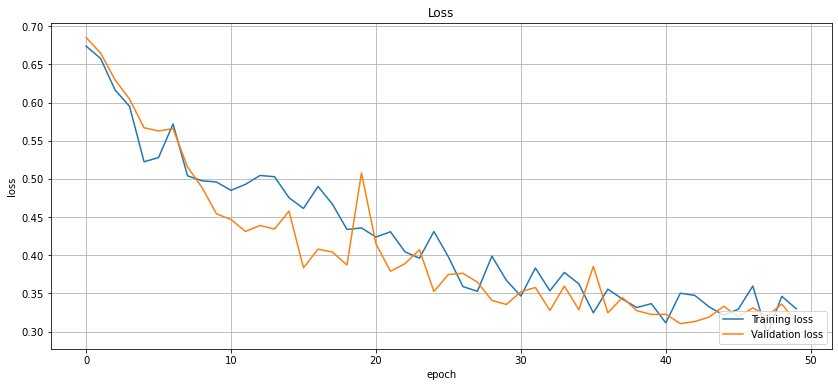

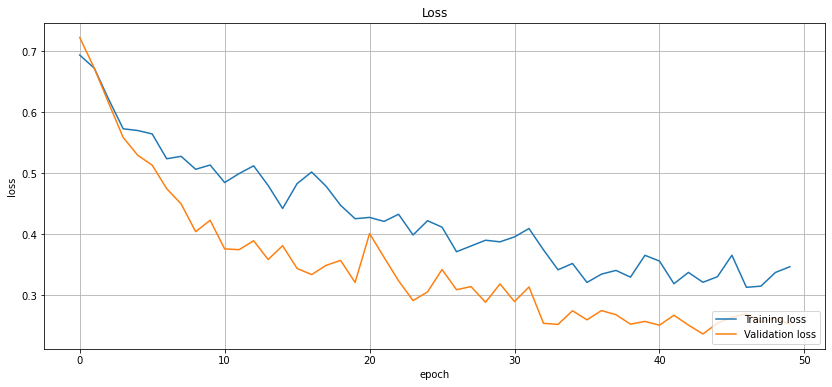

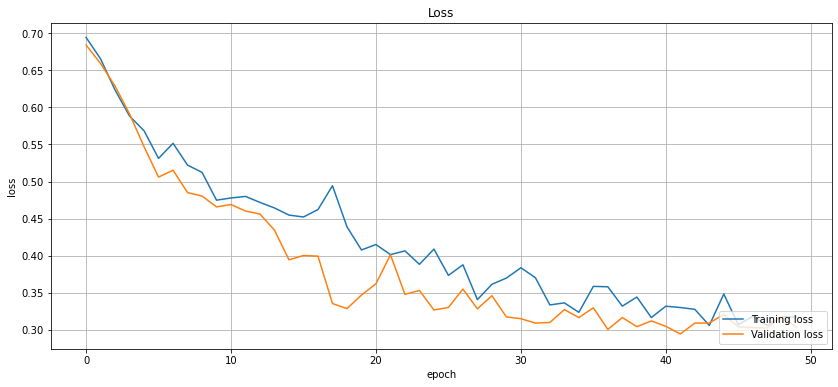

In [20]:
for fold in range(0, FOLDS):
    plot_loss(histories[fold])

In [21]:
# load all models in models[] for following computations
models = []

for fold in range(1, FOLDS + 1):
    print('Loading model for fold n.:', fold+1)
    model = build_model(dim=IMG_SIZES, ef=EFF_NETS)
    
    model.load_weights('fold-%i.h5'%fold)
    
    models.append(model)

print('Loading models completed !')

Loading model for fold n.: 2
Loading model for fold n.: 3
Loading model for fold n.: 4
Loading model for fold n.: 5
Loading model for fold n.: 6
Loading models completed !


In [22]:
# compute on test set,. ON test set no augmentation

files_test = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

num_total_test_files = len(files_test)

list_auc = []
list_acc = []

for fold in range(1, FOLDS + 1):
    print('Predicting with model:', fold)
    model = models[fold - 1]
    
    test_loss, test_auc, test_acc = model.evaluate(get_test_dataset(files_test), verbose = 1, batch_size = BATCH_SIZE,
                                        steps = count_data_items(files_test)/BATCH_SIZE)

    print('Test AUC: ', round(test_auc, 3))
    print('Test ACC: ', round(test_acc, 3))
    print('')
    
    list_auc.append(test_auc)
    list_acc.append(test_acc)

# compute avg, std
np_auc = np.array(list_auc)
np_acc = np.array(list_acc)

avg_auc = np.mean(np_auc)
std_auc = np.std(np_auc)
avg_acc = np.mean(np_acc)
std_acc = np.std(np_acc)

print('AUC: %.3f , std: %.3f' %(avg_auc, std_auc))
print('ACC: %.3f , std: %.3f' %(avg_acc, std_acc))

Predicting with model: 1
56/56 [==============================] - 12s 219ms/step - loss: 0.1860 - auc: 0.9839 - accuracy: 0.9390
Test AUC:  0.984
Test ACC:  0.939

Predicting with model: 2
56/56 [==============================] - 12s 216ms/step - loss: 0.1669 - auc: 0.9875 - accuracy: 0.9457
Test AUC:  0.987
Test ACC:  0.946

Predicting with model: 3
56/56 [==============================] - 12s 207ms/step - loss: 0.2011 - auc: 0.9883 - accuracy: 0.9301
Test AUC:  0.988
Test ACC:  0.93

Predicting with model: 4
56/56 [==============================] - 12s 214ms/step - loss: 0.1961 - auc: 0.9829 - accuracy: 0.9412
Test AUC:  0.983
Test ACC:  0.941

Predicting with model: 5
56/56 [==============================] - 12s 214ms/step - loss: 0.1808 - auc: 0.9881 - accuracy: 0.9494
Test AUC:  0.988
Test ACC:  0.949

AUC: 0.986 , std: 0.002
ACC: 0.941 , std: 0.007


In [23]:
# all the label from the test dataset
y_true = np.concatenate([y for x, y in get_test_dataset(files_test)], axis=0)

In [24]:
avg_preds = np.zeros((count_data_items(files_test), 1))

for fold in range(1, FOLDS + 1):
    model = models[fold - 1]
    
    print('Predicting  on fold:', fold)
    
    preds = model.predict(get_test_dataset(files_test), verbose = True,
                          steps = count_data_items(files_test)/BATCH_SIZE)
    
    avg_preds += preds * 1./FOLDS

Predicting  on fold: 1
56/56 [==============================] - 12s 209ms/step
Predicting  on fold: 2
56/56 [==============================] - 12s 211ms/step
Predicting  on fold: 3
56/56 [==============================] - 12s 208ms/step
Predicting  on fold: 4
56/56 [==============================] - 12s 208ms/step
Predicting  on fold: 5
56/56 [==============================] - 12s 209ms/step


In [25]:
# convert probabilities in labels
THRESHOLD = 0.50

y_pred = np.concatenate([y for y in avg_preds], axis=0)
y_pred = y_pred > THRESHOLD
y_pred = y_pred.astype(int)

acc = accuracy_score(y_true, y_pred)

print('The accuracy on TEST set is:', round(acc, 3))

The accuracy on TEST set is: 0.949


In [26]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

print('The Confusion Matrix')
print('TP:', tp)
print('TN:', tn)
print('FP:', fp)
print('FN:', fn)

The Confusion Matrix
TP: 630
TN: 645
FP: 46
FN: 23


In [27]:
SENS = tp/float(fn + tp)
SPEC = tn/float(tn + fp)

print('SENS:', round(SENS, 3))
print('SPEC:', round(SPEC, 3))

SENS: 0.965
SPEC: 0.933


In [28]:
# check accuracy, FP, FN for different thresholds

# check for thresholds from 0.40 to 0.70
THRESHOLDS = list(np.arange(0.40, 0.70, 0.01))

list_values = []
list_f1 = []

for THRESHOLD in THRESHOLDS:
    y_pred = np.concatenate([y for y in avg_preds], axis=0)
    y_pred = y_pred > THRESHOLD
    y_pred = y_pred.astype(int)
    
    acc = accuracy_score(y_true, y_pred)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    SENS = tp/float(fn + tp)
    SPEC = tn/float(tn + fp)
    PREC = tp / (tp + fp)
    F1_score = 2*PREC*SENS/float((PREC + SENS))
    
    list_f1.append(F1_score)
    
    list_values.append([THRESHOLD, tp, tn, fp, fn, SENS, SPEC, PREC, F1_score, acc])

In [29]:
# transform in a Dataframe
stat_df = pd.DataFrame(list_values, columns=['thr','tp','tn','fp','fn', 'Sens', 'Spec', 'Prec','F1-score', 'acc'])

# stat_df.head(21)

# output to csv
stat_df.to_csv('stat_df.csv', index=False)

In [30]:
stat_df.head(21)

,thr,tp,tn,fp,fn,Sens,Spec,Prec,F1-score,acc
0,0.40,635,608,83,18,0.972435,0.879884,0.884401,0.926331,0.924851
1,0.41,635,611,80,18,0.972435,0.884226,0.888112,0.928363,0.927083
2,0.42,635,616,75,18,0.972435,0.891462,0.894366,0.931768,0.930804
3,0.43,635,618,73,18,0.972435,0.894356,0.896893,0.933137,0.932292
4,0.44,633,622,69,20,0.969372,0.900145,0.901709,0.934317,0.933780
5,0.45,632,624,67,21,0.967841,0.903039,0.904149,0.934911,0.934524
6,0.46,631,629,62,22,0.966309,0.910275,0.910534,0.937593,0.937500
7,0.47,631,630,61,22,0.966309,0.911722,0.911850,0.938290,0.938244
8,0.48,631,636,55,22,0.966309,0.920405,0.919825,0.942494,0.942708
9,0.49,631,644,47,22,0.966309,0.931983,0.930678,0.948159,0.948661


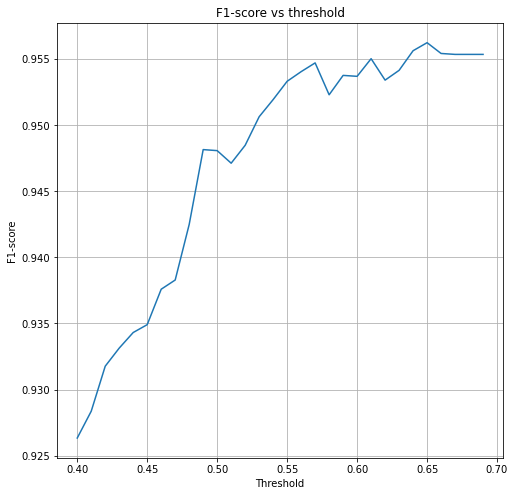

In [31]:
# plot f1 score vs thresholds
plt.figure(figsize=(8,8))
plt.plot(THRESHOLDS, list_f1)
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.title('F1-score vs threshold')
plt.grid()